## 1. Data Preparing

In [1]:
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook
import pandas as pd
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

# Load data
normal_df = pd.read_csv('processed_data/normal_data.csv')
fraud_df = pd.read_csv("processed_data/data_fraud_meter.csv")

fraud_df= utils.large_change_handling(fraud_df)
fraud_df = utils.normalize_data_frequency(fraud_df)

# Replacing index
fraud_df['IS_FRAUD'] = True
fraud_df.reset_index(inplace=True)

# Concatenating normal and fraud data
summary_df = pd.concat([normal_df, fraud_df])
summary_df['IMPORT_KWH_SHIFT1'] = summary_df.groupby("MA_DIEMDO").MILESTONE_IMPORT_KWH.shift(1)
summary_df['CONSUMPTION'] = summary_df.MILESTONE_IMPORT_KWH - summary_df.IMPORT_KWH_SHIFT1
summary_df = summary_df.rename(columns = {"index" : "TIME"})
summary_df.TIME = pd.to_datetime(summary_df.TIME)

/home/cpc/utils.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  diemdo_df = diemdo_df.set_index("NEAREST_HOUR").loc[time_index]


In [ ]:
summary_df.head()

In [3]:
summary_df.to_csv(index = False)

In [2]:
fraud_df.describe()

,MILESTONE_IMPORT_KWH
count,134141.000000
mean,2868.630017
std,3914.215349
min,0.000000
25%,700.648689
50%,1710.470132
75%,3489.808767
max,36448.163915


In [3]:
# List fraud MA_DIEMDO and normal MA_DIEMDO
list_mdd_fraud = list(set(fraud_df['MA_DIEMDO']))
list_mdd_normal = list(set(normal_df['MA_DIEMDO']))

In [4]:
summary_df.head()

,TIME,MILESTONE_IMPORT_KWH,MA_DIEMDO,IS_FRAUD,IMPORT_KWH_SHIFT1,CONSUMPTION
0,2017-01-01 06:00:00,0.000000,PP01000100340001,False,NaN,NaN
1,2017-01-01 12:00:00,0.913215,PP01000100340001,False,0.000000,0.913215
2,2017-01-01 18:00:00,2.639168,PP01000100340001,False,0.913215,1.725953
3,2017-01-02 00:00:00,3.711158,PP01000100340001,False,2.639168,1.071990
4,2017-01-02 06:00:00,4.783148,PP01000100340001,False,3.711158,1.071990


In [5]:
# Saving Check point
temp_summary_df = summary_df

## 2. Convert into interval of time data (monthly)

In [6]:
def get_month(date_time):
    month = str(date_time.month)
    year = str(date_time.year)
    return pd.Timestamp(year + '-' + month)

summary_df['MONTH'] = summary_df['TIME'].apply(get_month)
#summary_df.set_index('index', drop=True, inplace=True)
#list_month = [get_month(_x) for _x in summary_df.index if _x not in summary_df.index]

In [7]:
test_summary = summary_df
mean_consumption = test_summary.groupby(["MA_DIEMDO", "MONTH"])['CONSUMPTION'].mean().reset_index()
list_diemdo = list(set(mean_consumption['MA_DIEMDO']))

In [8]:
mean_consumption.head()

,MA_DIEMDO,MONTH,CONSUMPTION
0,PP01000100340001,2017-01-01,0.866166
1,PP01000100340001,2017-02-01,1.016763
2,PP01000100340001,2017-03-01,0.836267
3,PP01000100340001,2017-04-01,0.900872
4,PP01000100340001,2017-05-01,1.017066


In [9]:
dict_df = {}
dict_df['MA_DIEMDO'] = list_diemdo
first_dd = list(mean_consumption.loc[mean_consumption['MA_DIEMDO'] == list_diemdo[0]]['CONSUMPTION'])
lack_mdd = []

is_drop_missing = True

for i in range(len(first_dd)):
    res_value = []
    for _mdd in list_diemdo :
        try :
            res_value.append(list(mean_consumption.loc[mean_consumption['MA_DIEMDO'] == _mdd]['CONSUMPTION'])[i])
        except :
            lack_mdd.append(_mdd)
            res_value.append(0)
            # Treat missing value as 0 - NEED more working.
    dict_df[str(mean_consumption['MONTH'][i])[:7]] = res_value
    
# drop missing data
is_drop_missing = False
if is_drop_missing:
    for _mdd in list(set(lack_mdd)):
        df_monthly.drop(df_monthly[df_monthly.MA_DIEMDO == _mdd].index, inplace=True)


In [10]:
df_monthly = pd.DataFrame(dict_df)
df_monthly.head()

,MA_DIEMDO,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07
0,PP03000827897001,1.154645,1.108245,1.174051,1.327140,1.470473,1.661291,1.621505,1.684448,1.593583,1.395699,1.393775,1.290296,1.189547,1.381835,1.347467,1.477262,1.612134,1.690684,1.904294
1,PP05000508274001,0.851681,0.137619,1.247368,1.410689,1.604900,1.885101,1.812852,1.756412,1.828342,1.840140,1.865494,2.160336,1.532079,0.019865,1.103588,1.233135,1.387616,1.651414,1.667661
2,PP09000822050001,1.045826,0.987852,1.054474,1.239425,1.317627,1.412615,1.304950,1.429046,1.242178,1.037788,1.055377,0.976179,0.948727,1.049137,1.072566,1.314098,1.590220,1.514182,1.606753
3,PP07000615724001,0.734322,0.751080,0.778040,0.941982,1.065895,1.029243,0.957226,1.022595,1.163367,1.010129,0.852611,0.901390,0.961588,0.985453,1.146292,1.293640,1.138905,1.266295,1.573106
4,PP01000618521001,1.759665,1.735157,1.906509,1.929912,1.929812,1.891065,1.803975,1.973250,1.968864,1.907773,1.829137,1.843607,1.873303,1.858004,1.884318,1.964549,2.121511,2.634519,3.415732


In [11]:
total_missing_month = len(list(set(lack_mdd)))
print("Total data missing : ", total_missing_month)
print("Shape of data set :", df_monthly.shape)

Total data missing :  174
Shape of data set : (1070, 20)


## 3. Visualizing monthly data

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt

list_month = list(df_monthly.columns[1:])

# Prep color
np.random.seed(100)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), df_monthly.shape[0], replace = True)

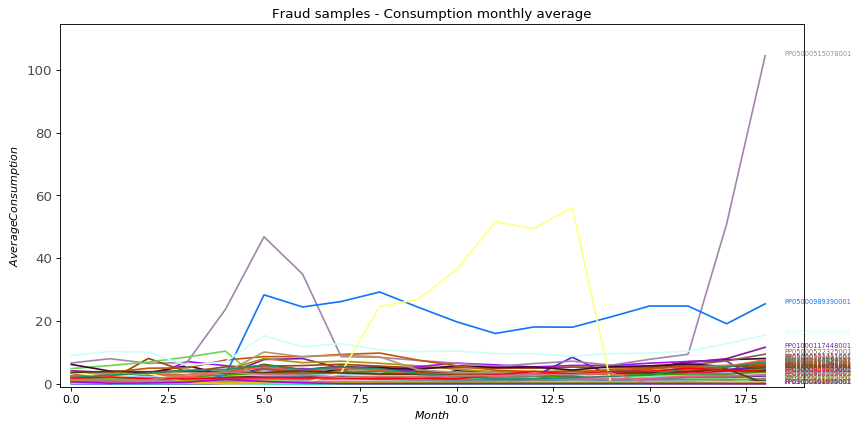

In [77]:
# Draw plotting of fraud MA_DIEMDO
plt.figure(figsize = (12, 6), dpi = 80)
max_y = 0
for i, y in enumerate(list_mdd_fraud):
    ind = df_monthly.loc[df_monthly['MA_DIEMDO'] == y].index.tolist()
    Y = list(df_monthly.iloc[ind[0], :])[1:]
    X = list(range(df_monthly.shape[1] - 1))
    max_y = max(max_y, max(Y))
    #print(y, Y, '-', max(Y))
    #print("\n")
    plt.plot(X, Y, color = colors[i], label = y)
    plt.text(df_monthly.shape[1] - 1.5, Y[-1], y , fontsize = 6, color = colors[i])
plt.gca().set(xlim = (-0.3, 19), ylim = (-1, max_y + 10), ylabel = '$Average Consumption$', xlabel = '$Month$')
plt.yticks(fontsize = 12, alpha = 0.7)
plt.title("Fraud samples - Consumption monthly average")
plt.show()

In [78]:
# Example of 1 outlier sample : 
df_monthly.loc[df_monthly['MA_DIEMDO'] == 'PP05000515078001']

,MA_DIEMDO,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07
19,PP05000515078001,6.587102,7.952913,6.467697,6.739981,23.712242,46.821451,34.918339,8.612311,8.379496,7.392928,6.512599,5.526874,6.389343,7.163209,5.878186,7.756148,9.355352,50.900468,104.537305


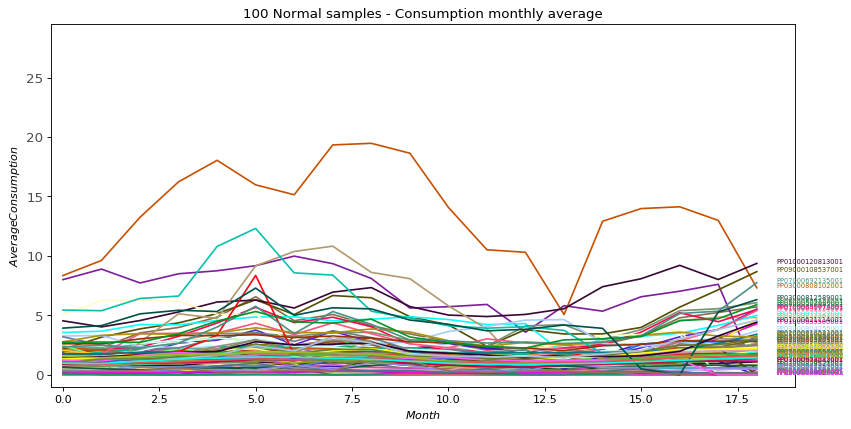

In [79]:
# Draw plotting of a small part from normal MA_DIEMDO
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rd

# Prep color
np.random.seed(100)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), df_monthly.shape[0], replace = True)

list_100mdd_normal = rd.choices(list_mdd_normal, k=100)
plt.figure(figsize = (12, 6), dpi = 80)
max_y = 0
for i, y in enumerate(list_100mdd_normal):
    ind = df_monthly.loc[df_monthly['MA_DIEMDO'] == y].index.tolist()
    Y = list(df_monthly.iloc[ind[0], :])[1:]
    X = list(range(df_monthly.shape[1] - 1))
    max_y = max(max_y, max(Y))
    #print(y, Y, '-', max(Y))
    #print("\n")
    plt.plot(X, Y, color = colors[i], label = y)
    plt.text(df_monthly.shape[1] - 1.5, Y[-1], y , fontsize = 6, color = colors[i])
plt.gca().set(xlim = (-0.3, 19), ylim = (-1, max_y + 10), ylabel = '$Average Consumption$', xlabel = '$Month$')
plt.yticks(fontsize = 12, alpha = 0.7)
plt.title("100 Normal samples - Consumption monthly average")
plt.show()

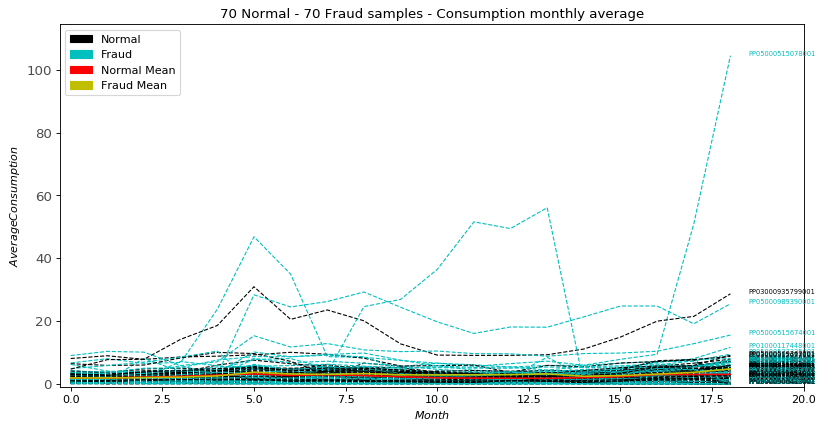

In [80]:
# Draw Fraud and Normal MA_DIEMDO
import matplotlib.patches as mpatches

fraud_cl = 'c'
normal_cl = 'black'

list_70mdd_normal = rd.choices(list_mdd_normal, k=70)

plt.figure(figsize = (12, 6), dpi = 80)
max_y = 0
sum_Y1 = np.zeros(19)
sum_Y2 = np.zeros(19)
for i, y in enumerate(list_70mdd_normal):
    X = list(range(df_monthly.shape[1] - 1))
    ind1 = df_monthly.loc[df_monthly['MA_DIEMDO'] == y].index.tolist()
    Y1 = list(df_monthly.iloc[ind1[0], :])[1:]
    ind2 = df_monthly.loc[df_monthly['MA_DIEMDO'] == list_mdd_fraud[i]].index.tolist()
    Y2 = list(df_monthly.iloc[ind2[0], :])[1:]
    max_y = max(max_y, max(Y), max(Y2))
    sum_Y1 += np.array(Y1)
    sum_Y2 += np.array(Y2)
    plt.plot(X, Y1, color = normal_cl, linestyle='dashed', linewidth = 1)
    plt.text(df_monthly.shape[1] - 1.5, Y1[-1], y , fontsize = 6, color = normal_cl)
    plt.plot(X, Y2, color = fraud_cl, linestyle='dashed', linewidth = 1)
    plt.text(df_monthly.shape[1] - 1.5, Y2[-1], list_mdd_fraud[i] , fontsize = 6, color = fraud_cl)
Y1_mean = sum_Y1/70
Y2_mean = sum_Y2/70

plt.plot(X, Y1_mean, color = 'r')
plt.plot(X, Y2_mean, color = 'y')

plt.gca().set(xlim = (-0.3, 20), ylim = (-1, max_y + 10), ylabel = '$Average Consumption$', xlabel = '$Month$')
plt.yticks(fontsize = 12, alpha = 0.7)
patch_1 = mpatches.Patch(color='black', label='Normal')
patch_2 = mpatches.Patch(color='c', label='Fraud')

patch_3 = mpatches.Patch(color='r', label='Normal Mean')
patch_4 = mpatches.Patch(color='y', label='Fraud Mean')

plt.legend(handles=[patch_1, patch_2, patch_3, patch_4])
plt.title("70 Normal - 70 Fraud samples - Consumption monthly average")
plt.show()

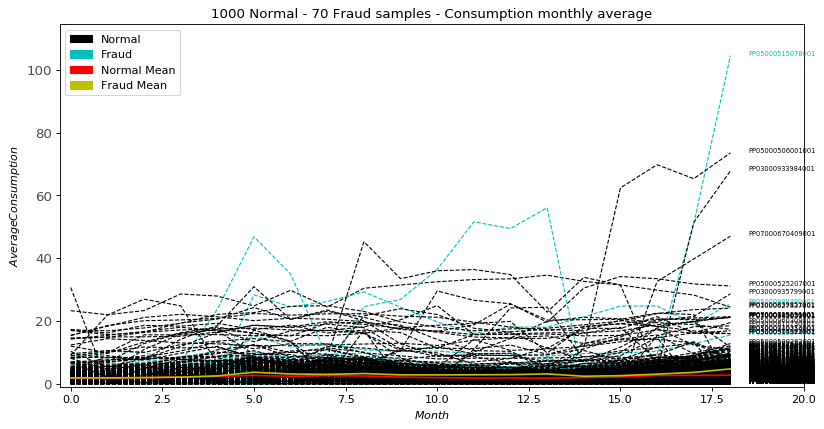

In [81]:
# Draw Fraud and all Normal MA_DIEMDO
import matplotlib.patches as mpatches

fraud_cl = 'c'
normal_cl = 'black'

list_1000mdd_normal = list_mdd_normal

plt.figure(figsize = (12, 6), dpi = 80)
max_y = 0
sum_Y1 = np.zeros(19)
sum_Y2 = np.zeros(19)
for i, y in enumerate(list_1000mdd_normal):
    X = list(range(df_monthly.shape[1] - 1))
    ind1 = df_monthly.loc[df_monthly['MA_DIEMDO'] == y].index.tolist()
    Y1 = list(df_monthly.iloc[ind1[0], :])[1:]

    max_y = max(max_y, max(Y), max(Y2))
    sum_Y1 += np.array(Y1)
    plt.plot(X, Y1, color = normal_cl, linestyle='dashed', linewidth = 1)
    plt.text(df_monthly.shape[1] - 1.5, Y1[-1], y , fontsize = 6, color = normal_cl)
    if i <= 69 :
        ind2 = df_monthly.loc[df_monthly['MA_DIEMDO'] == list_mdd_fraud[i]].index.tolist()
        Y2 = list(df_monthly.iloc[ind2[0], :])[1:]
        plt.plot(X, Y2, color = fraud_cl, linestyle='dashed', linewidth = 1)
        plt.text(df_monthly.shape[1] - 1.5, Y2[-1], list_mdd_fraud[i] , fontsize = 6, color = fraud_cl)
        sum_Y2 += np.array(Y2)
        
Y1_mean = sum_Y1/len(list_1000mdd_normal)
Y2_mean = sum_Y2/len(list_mdd_fraud)

plt.plot(X, Y1_mean, color = 'r')
plt.plot(X, Y2_mean, color = 'y')

plt.gca().set(xlim = (-0.3, 20), ylim = (-1, max_y + 10), ylabel = '$Average Consumption$', xlabel = '$Month$')
plt.yticks(fontsize = 12, alpha = 0.7)
patch_1 = mpatches.Patch(color='black', label='Normal')
patch_2 = mpatches.Patch(color='c', label='Fraud')

patch_3 = mpatches.Patch(color='r', label='Normal Mean')
patch_4 = mpatches.Patch(color='y', label='Fraud Mean')

plt.legend(handles=[patch_1, patch_2, patch_3, patch_4])
plt.title("1000 Normal - 70 Fraud samples - Consumption monthly average")
plt.show()

## 4. SAX ( for Value Reducing ) and PCA/interval adjust (for Dim Reducing) ... 

## 5. Clustering Implementation 1

In [13]:
# Try K-means Approaching

# STEP 1: Intitial
X = df_monthly.iloc[:, 1:].values
m = X.shape[0] # number of samples
n = X.shape[1] # number of monthly features

# Storing reverse_dict for testing result later
reverse_dict = {}
for i in range(m):
    reverse_dict[(df_monthly.iloc[i, 1], df_monthly.iloc[i, 2], df_monthly.iloc[i, 3], df_monthly.iloc[i, 4])] = df_monthly.iloc[i, 0]

import random as rd
def K_Mean(X, n_iters, cluster_number):
    centroid = np.array([]).reshape(n, 0)
    for i in range(cluster_number):
        centroid = np.c_[centroid, X[rd.randint(0, m-1)]]
    # Centroid is a n x cluster_number dimentional matrix, where each column will be a centroid for one cluster

# STEP 2: Assign points to each clusters (based on ED distance)
    Y = {}
    for i in range(n_iters):
        
        EuclidianDistance = np.array([]).reshape(m,0)
        for j in range(cluster_number):
            tempDist = np.sum((X - centroid[:, j])**2,axis=1)
            EuclidianDistance = np.c_[EuclidianDistance, tempDist]
        C = np.argmin(EuclidianDistance, axis=1) + 1

        for k in range(cluster_number):
            Y[k+1] = np.array([]).reshape(n,0)
        for i in range(m):
            Y[C[i]] = np.c_[Y[C[i]],X[i]]
        for k in range(cluster_number):
            Y[k+1] = Y[k+1].T
        for k in range(cluster_number):
            centroid[:,k] = np.mean(Y[k+1], axis=0)
    return Y, centroid

In [83]:
n_iters = 200
cluster_number = 3
Clustering_result_1, centroid_1 = K_Mean(X, n_iters, cluster_number)
for _item in Clustering_result_1 :
    print("Cluster ", _item, ' - ', len(Clustering_result_1[_item]),)

Cluster  1  -  866
Cluster  2  -  182
Cluster  3  -  22


In [84]:
# Information distances among cluster's centers
from prettytable import PrettyTable
import math
t = PrettyTable(['Cluster'] + list(Clustering_result_1.keys()))

def square(_list):
    return [_ele ** _ele for _ele in _list]

for i in range(cluster_number):
    row_i = [list(Clustering_result_1.keys())[i]]
    for j in range(cluster_number):
        centroid_i = np.array([_cent[i] for _cent in  centroid_1])
        centroid_j = np.array([_cent[j] for _cent in  centroid_1])
        EDist_cluster_ij = math.sqrt(sum(square(centroid_i - centroid_j)))
        row_i.append(int(EDist_cluster_ij))
    t.add_row(row_i)
print(t)

+---------+-----+-----+-----+
| Cluster |  1  |  2  |  3  |
+---------+-----+-----+-----+
|    1    |  0  |  52 | 294 |
|    2    |  52 |  0  | 242 |
|    3    | 294 | 242 |  0  |
+---------+-----+-----+-----+


Can see cluster 6 - 7 is far from the others  

In [85]:
# Visualizing result in 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit(X)
X_principal = pca.fit_transform(X)
result_2D = {}
for _item in Clustering_result_1 :
    result_2D[_item] = []
    for _point in Clustering_result_1[_item]:
        result_2D[_item].append(principalComponents.transform([_point])[0])

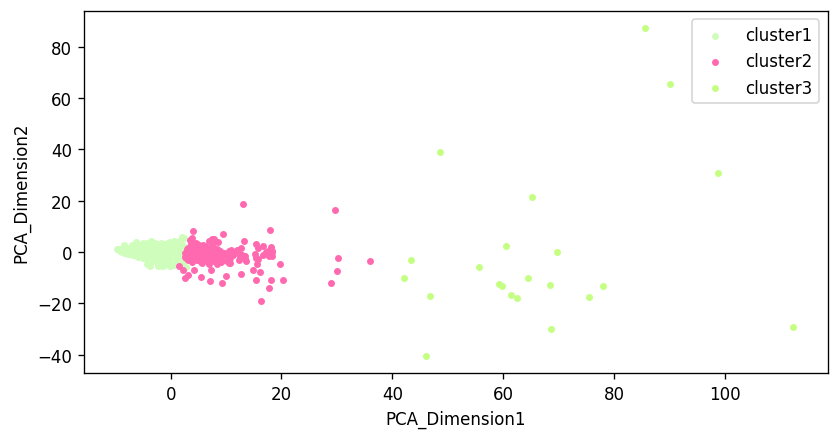

In [86]:
def clustering_plt2D(result = result_2D, cluster_number = 7, centroid = centroid_1):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    plt.figure(figsize = (8, 4), dpi = 120)
    colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    labels=['cluster' + str(i+1) for i in range(cluster_number)]
    
    for k in range(cluster_number):
        d1 = [result[k+1][i][0] for i in range(len(result[k+1]))]
        d2 = [result[k+1][i][1] for i in range(len(result[k+1]))]
        plt.scatter(d1, d2, c=colors[k], s=10, label=labels[k])
    #plt.scatter(centroid[0,:], centroid[1,:], s=60, c='yellow', label='Centroids')
    plt.xlabel('PCA_Dimension1')
    plt.ylabel('PCA_Dimension2')
    plt.legend()
    plt.show()
clustering_plt2D(result_2D, cluster_number, centroid_1)
# PCA 19D -> 2D is not good at visualizing??? but still give notice about cluster 6 and 7

In [87]:
# Bar chart plotting - samples in clusters vs fraud samples 
df_cluster = pd.DataFrame([len(_cl) for _cl in Clustering_result_1.values()])
list_fraud = [0]*cluster_number
cluster_mdd = {}
for k in Clustering_result_1 :
    cluster_mdd[k] = []
    for v in Clustering_result_1[k]:
        mdd = reverse_dict[v[0], v[1], v[2], v[3]]
        cluster_mdd[k].append(mdd)

for _fr in list_mdd_fraud:
    is_point_in = False
    for k in cluster_mdd.keys():
        if _fr in cluster_mdd[k]:
            is_point_in = True
            list_fraud[k-1] += 1
    if not is_point_in :
        print("Fail one.")
df_fraud = pd.DataFrame(list_fraud)
df_cluster_fraud = pd.concat([df_cluster.T, df_fraud.T], axis=0, ignore_index=False)
df_cluster_fraud.rename(columns = dict(zip(list(range(cluster_number)), ['cluster ' + str(i+1) for i in range(cluster_number)])), 
                 inplace=True)
df_cluster_fraud['type'] = ['summary', 'fraud']
df_cluster_fraud

,cluster 1,cluster 2,cluster 3,type
0,866,182,22,summary
0,49,18,3,fraud


## 5'.Conspicious experiment

In [88]:
# Cluster 6, 7 is conspicious
conspicious_set_1 = [*Clustering_result_1[6], *Clustering_result_1[7]]

KeyError: 6

In [ ]:
# Find another conspicious set
cluster_number_2= 10
n_iters_2 = 100
Clustering_result_2, centroid_2 = K_Mean(X, n_iters_2, cluster_number_2)
for _item in Clustering_result_2 :
    print("Cluster ", _item, ' - ', len(Clustering_result_2[_item]),)

In [ ]:
from prettytable import PrettyTable
import math
t = PrettyTable(['Cluster'] + list(Clustering_result_2.keys()))
for i in range(cluster_number_2):
    row_i = [list(Clustering_result_2.keys())[i]]
    for j in range(cluster_number_2):
        centroid_i = np.array([_cent[i] for _cent in  centroid_2])
        centroid_j = np.array([_cent[j] for _cent in  centroid_2])
        EDist_cluster_ij = math.sqrt(sum((centroid_i - centroid_j))**2)
        row_i.append(int(EDist_cluster_ij))
    t.add_row(row_i)
print(t)

In [ ]:
# Cluster 8, 4 is conspicious
conspicious_set_2 = [*Clustering_result_2[8], *Clustering_result_2[4]]

In [ ]:
def relevant_2list(l1, l2):
    # List contain n-dimension points
    n1 = len(l1)
    n2 = len(l2)
    dup_i = dup_i_rev = 0
    for i in l1 :
        if i in l2 :
            dup_i += 1
    for j in l2 :
        if j in l1 :
            dup_i_rev += 1
    return (dup_i/n1 + dup_i_rev/n2)/2

In [ ]:
mdd_conspicous_1 = [reverse_dict[i[0]] for i in conspicious_set_1]

In [ ]:
mdd_conspicous_2 = [reverse_dict[i[0]] for i in conspicious_set_2]

In [ ]:
relevant_2list(mdd_conspicous_1, mdd_conspicous_2)

## 6. Clustering Implementation 2

In [89]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [90]:
X = df_monthly.iloc[:, 1:].values
m = X.shape[0] # number of samples
n = X.shape[1] # number of monthly features


In [91]:
# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.33160898, -0.39090405, -0.35573798, ...,  0.04139648,
         0.1787073 ,  0.40741158],
       [-0.26741251, -0.23109104, -0.23733845, ..., -0.26822632,
        -0.26672198, -0.21941565],
       [-0.52553169, -0.62348483, -0.61747067, ..., -0.23651487,
        -0.34417642,  0.36230103],
       ...,
       [-0.07921154, -0.1179659 , -0.1202922 , ..., -0.24520078,
        -0.2091742 , -0.16950351],
       [-0.3816554 , -0.43296041, -0.42729089, ...,  0.07144101,
         0.04738481,  0.04164931],
       [ 0.07592637,  0.00340963, -0.13932927, ..., -0.18546704,
        -0.18086463, -0.51439714]])

In [92]:
# Normalizing the data so that the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)
X_normalized.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.284634,-0.335530,-0.305345,-0.212047,-0.126565,-0.115681,-0.117084,-0.007373,-0.026852,-0.27241,-0.350184,-0.237904,-0.267042,-0.227684,-0.261676,-0.179383,0.035532,0.153392,0.349699
1,-0.233982,-0.202202,-0.207668,-0.289109,-0.304863,-0.299905,-0.252376,-0.335365,-0.245653,-0.24568,-0.178912,-0.193568,-0.168646,-0.123907,-0.130813,-0.145309,-0.234695,-0.233378,-0.191986
2,-0.249278,-0.295740,-0.292887,-0.309496,-0.320113,-0.313818,-0.311478,-0.294662,-0.290165,-0.17570,-0.120514,-0.121300,-0.149337,-0.118015,-0.146564,-0.115081,-0.112187,-0.163255,0.171852


In [93]:
#  Reducing the dimensionality of the data to make it visualizable
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
X_principal.head()

,P1,P2
0,-0.257971,0.665893
1,-0.626920,-0.066246
2,-0.547318,0.210197
3,-0.627156,0.030659
4,-0.623262,-0.014161


In [94]:
#Building the clustering model Numpy array of all the cluster labels assigned to each data point 
db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal)
labels_1 = db_default.labels_

In [97]:
labels_1

array([-1,  0,  0, ...,  0,  5, -1])

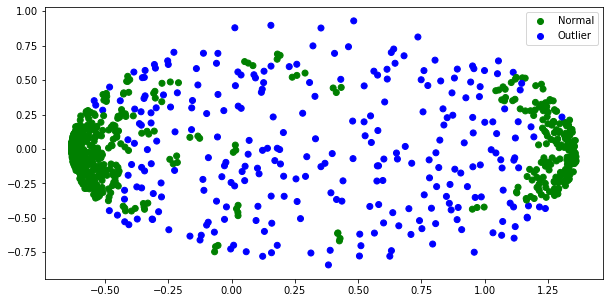

Number of clusters :  29
Number of outliers :  275
Number of clustered points :  795


In [249]:


# Building the colour vector for each data point
def plotting_DBSCAN(labels):
    colors_normal = 'g'
    colors_outlier = 'b'
    cvec = []
    n_outliers = 0
    for _lab in labels:
        if _lab != -1 :
            cvec.append(colors_normal)
        else :
            cvec.append(colors_outlier)
            n_outliers += 1
    # For the construction of the legend of the plot
    #g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g')
    #b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b') 

    # Plotting P1 on the X-Axis and P2 on the Y-Axis
    # according to the colour vector defined
    plt.figure(figsize =(10, 5))
    plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
    # Building the legend
    plt.legend((g, b), ('Normal', 'Outlier'))
    plt.show()

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = list(labels).count(-1)
    print("Number of clusters : ", n_clusters_)
    print("Number of outliers : ", n_outliers)
    print("Number of clustered points : ", len(labels) - n_outliers)
plotting_DBSCAN(labels_1)


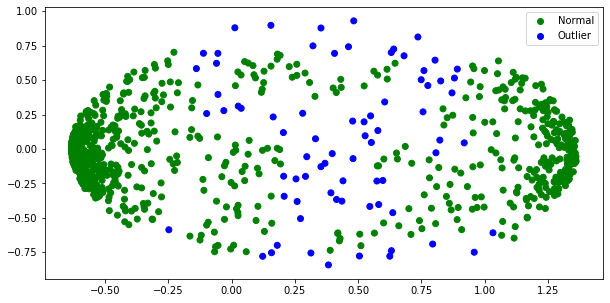

Number of clusters :  13
Number of outliers :  75
Number of clustered points :  995


In [275]:
#Tuning the parameters of the model

db_tuning = DBSCAN(eps = 0.097, min_samples = 5, metric = 'euclidean', algorithm = 'auto').fit(X_principal)
labels_2 = db_tuning.labels_
plotting_DBSCAN(labels_2)

In [285]:
# Comparing to fraud DataFrame
list_outlier_DBSCAN = []
for i, lab in enumerate(labels_2):
    if lab == -1 :
        list_outlier_DBSCAN.append(reverse_dict[(X[i][0], X[i][1], X[i][2], X[i][3])])

75

In [284]:
relevant_2list(list_outlier_DBSCAN, list_mdd_fraud)

0.12428571428571428

## To do 

+ Chỉnh phần visualizing Fraud + Normal vào cùng một đồ thị
+ Cluster xong, vẽ biểu đồ phân phối của (khoảng cách Fraud/Normal đến tâm Cluster) -> đánh giá
+ Tìm thêm ý tưởng clustering abnormal detection (time series)